# Figure. eQTL Overview

In [79]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_eqtl_overview'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
sns.set_style('white')

In [3]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_analysis', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)
sig = most_sig[most_sig.sig]

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'gene_variant_pairs.tsv')
gene_variant_pairs = pd.read_table(fn)

In [4]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)
res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results', 
                                 '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

g = gene_info[gene_info.gene_name == 'POU5F1'].index[0]
res = ciepy.read_emmax_output(res_fns[g])
res = res.sort_values('PVALUE')
    
t =  vcf_reader.fetch(res.CHROM.values[0], 
                      res.BEG.values[0], 
                      res.BEG.values[0] + 1)
r = t.next()
tdf = pd.DataFrame(exp.ix[g])
tdf.columns = ['expression']
tdf['genotype'] = 0
hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
tdf.ix[hets, 'genotype'] = 1
alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
tdf.ix[alts, 'genotype'] = 2
pou5f1_data = tdf
pou5f1_data.columns = ['Expression', 'Genotype']

In [ ]:
colors = {'CHD2':chd2_color, 'EGR1':egr1_color, 'DHS':dnase_color}

fig,ax = plt.subplots(1, 1, figsize=(1, 1))
ciepy.clean_axis(ax)
rects = []
labels = []
for k in ['CHD2', 'EGR1', 'DHS']:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=colors[k]))
lgd = ax.legend(rects, labels, loc='center', fancybox=True, prop={'size':8}) #,ncol=8)
for p in lgd.get_patches():
    p.set_linewidth(0)
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'pou5f1_ucsc_legend.pdf'), transparent=True)

In [ ]:
egr1_color = "#20B2AA"
chd2_color = "#DB7093"
dnase_color = "#663399"

In [218]:
legend_colors = [
    egr1_color, 
    np.array((255,0,0)) / 255.,
    np.array((255,105,105)) / 255.,
    np.array((250,202,0)) / 255.,
    chd2_color,
    np.array((255,252,4)) / 255.,
    np.array((10,190,254)) / 255.,
    np.array((0,176,80)) / 255.,
    dnase_color,
    np.array((0,176,80)) / 255.,
    np.array((153,255,102)) / 255.,
    np.array((245,245,245)) / 255.,
    ]
ind = [
    'EGR1 ChIP',
    'Active promoter',
    'Weak promoter',
    'Strong enhancer',
    'CHD2 ChIP',
    'Weak/poised enhancer',
    'Insulator',
    'Transcriptional transition',
    'DNase HS',
    'Transcriptional elongation',
    'Weak transcribed',
    'Heterochromatin',
]
legend_colors = pd.Series(legend_colors, index=ind)

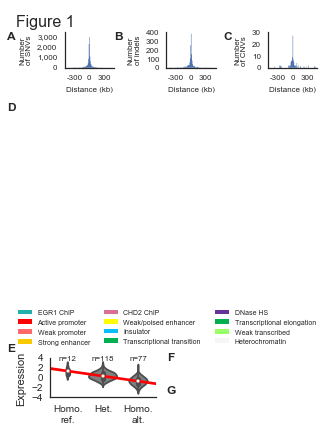

In [225]:
fig = plt.figure(figsize=(4.48, 6.1), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 0, 'Figure 1',
        size=16, va='bottom')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

gs = gridspec.GridSpec(1, 3)
ax = fig.add_subplot(gs[0, 0])
n,b,p = ax.hist(sig[sig.vtype == 'snp'].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number\nof SNVs', fontsize=8)
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_yticks(ax.get_yticks()[0::2])
    
ax = fig.add_subplot(gs[0, 1])
n,b,p = ax.hist(sig[(sig.vtype == 'ins') | (sig.vtype == 'del')].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number\nof indels', fontsize=8)
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_yticks(ax.get_yticks()[0::2])
    
ax = fig.add_subplot(gs[0, 2])
n,b,p = ax.hist(sig[sig.vtype == 'cnv'].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number\nof CNVs', fontsize=8)
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_yticks(ax.get_yticks()[0::2])
    
gs.tight_layout(fig, rect=[0, 0.75, 1, 0.95])

t = fig.text(0.005, 0.9, 'A', weight='bold', 
             size=12)
t = fig.text(0.335, 0.9, 'B', weight='bold', 
             size=12)
t = fig.text(0.675, 0.9, 'C', weight='bold', 
             size=12)

t = fig.text(0.005, 0.74, 'D', weight='bold', 
             size=12)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ciepy.clean_axis(ax)
rects = []
labels = []
for k in legend_colors.index:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=legend_colors[k]))
lgd = ax.legend(rects, labels, loc='center', prop={'size':7}, ncol=3)
for p in lgd.get_patches():
    p.set_linewidth(0)
gs.tight_layout(fig, rect=[0, 0.22, 1, 0.27])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax = sns.violinplot(x='Genotype', y='Expression', data=pou5f1_data, color='grey',
                    order=[0, 1, 2], scale='count')
sns.regplot(x='Genotype', y='Expression', data=pou5f1_data, scatter=False, color='red')
ya, yb = plt.ylim()
ax.set_xlabel('')
ax.set_xticklabels(['Homo.\nref.', 'Het.', 'Homo.\nalt.'])
plt.text(0, yb, 'n={}'.format(sum(tdf.Genotype == 0)), 
         verticalalignment='center', horizontalalignment='center', fontsize=8)
plt.text(1, yb, 'n={}'.format(sum(tdf.Genotype == 1)), 
         verticalalignment='center', horizontalalignment='center', fontsize=8)
plt.text(2, yb, 'n={}'.format(sum(tdf.Genotype == 2)), 
         verticalalignment='center', horizontalalignment='center', fontsize=8)
ax.set_yticks(ax.get_yticks()[0::2])
sns.despine(ax=ax)

gs.tight_layout(fig, rect=[0, 0, 0.5, 0.21])

t = fig.text(0.005, 0.19, 'E', weight='bold', 
             size=12)
t = fig.text(0.5, 0.17, 'F', weight='bold', 
             size=12)
t = fig.text(0.5, 0.095, 'G', weight='bold', 
             size=12)

plt.savefig(os.path.join(outdir, 'eqtl_overview_skeleton.pdf'))

In [223]:
%%R

suppressPackageStartupMessages(library(Gviz))
suppressPackageStartupMessages(library(GenomicFeatures))

In [7]:
gene_id = gene_info[gene_info.gene_name == 'POU5F1'].index[0]

res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results', 
                                 '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
res = ciepy.read_emmax_output(res_fns[gene_id])
res = res.sort_values('BEG')
res = res.dropna(subset=['PVALUE'])

res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results2', 
                                 '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
res2 = ciepy.read_emmax_output(res_fns[gene_id])
res2 = res2.sort_values('BEG')
res2 = res2.dropna(subset=['PVALUE'])

In [8]:
grange = res[['BEG']]
grange.columns = ['start']
grange['end'] = grange['start'] + 1
data = pd.DataFrame(-np.log10(res.PVALUE))
data = pd.DataFrame([-np.log10(res.PVALUE), -np.log10(res2.PVALUE)],
                    index=['one', 'two']).T
starts = res.BEG

chrom = 'chr6'
start = 31122118
end = 31158508
start = 31110081
end = 31164667
start=31110081
end=31164667
fontsize = 8

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [34]:
%%R -i data,grange,chrom,start,end,fontsize,starts

ideoTrack <- IdeogramTrack(
    genome="hg19", 
    fontsize=fontsize, 
    fontsize.legend=fontsize,
    fontcolor='black', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1
)

gtrack <- GenomeAxisTrack(
    col="black", 
    cex=1, 
    fontsize=8, 
    col.id="black", 
    fontcolor="black", 
    fontface=1,
    fontface.group=1,
    lwd=1,
)

gr <- GRanges(
    seqnames="chr6", 
    ranges=IRanges(start=starts, width=rep(1, length(starts))),
    primary=data["one"],
    secondary=data["two"]
    )

pvalTrack <- DataTrack(
    gr,
    groups=c("Primary", "Secondary"),
    genome="hg19", 
    type="p", 
    alpha=0.75, 
    lwd=8,
    name="-log10 p-value", 
    fontsize=8,
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=0.5, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    fontcolor.title="black",
    fontface.title=1, 
    alpha.title=1,
    cex.legend=1,
    fontcolor.legend="black",
    fontface.legend=1,
    fontsize.legend=8,
)

biomTrack <- BiomartGeneRegionTrack(
    genome="hg19", 
    chromosome=chrom, 
    start=start, 
    end=end,
    name="", 
    fontsize=fontsize,
    collapseTranscripts='meta',
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black', 
    fontcolor.legend="black",
    background.title='transparent', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1, 
    geneSymbols=TRUE,
    cex.group=1,
    fontcolor.group="black",
    fontface.group=1,
    fontface.title=1, 
    alpha.title=1,
    lwd=0.8,
)

hmmTrack <- UcscTrack(
    track="Broad ChromHMM", 
    table="wgEncodeBroadHmmH1hescHMM",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=8,
    name="H1-hESC",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

chd2Track <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsSydhH1hescChd2IggrabUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=8,
    name="CHD2",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

egr1Track <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsHaibH1hescEgr1V0416102UniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=8,
    name="EGR1",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

dnaseTrack <- UcscTrack(
    track="Uniform DNaseI HS", 
    table="wgEncodeAwgDnaseUwdukeH1hescUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=8,
    name="DHS",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

feat <- unique(feature(hmmTrack))
featCol <- setNames(as.list(rgb(t(sapply(strsplit(feat, ","),
as.numeric)), maxColorValue=255)), feat)
displayPars(hmmTrack) <- featCol

In [50]:
%%R -i egr1_color,chd2_color,dnase_color

egr1Track = setPar(egr1Track, "fill", egr1_color)
chd2Track = setPar(chd2Track, "fill", chd2_color)
dnaseTrack = setPar(dnaseTrack, "fill", dnase_color)

In [61]:
fn = os.path.join(outdir, 'pou5f1.pdf')

In [62]:
%%R -i fn,start,end

pdf(fn, 4.48, 3)
plotTracks(c(gtrack, biomTrack, pvalTrack, chd2Track, egr1Track, dnaseTrack, hmmTrack), chromosome="chr6", 
           from=start, to=end, col.title="black", sizes=c(1.5, 1.5, 5, 0.25, 0.25, 0.25, 0.25))
dev.off()

png 
  2 


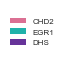

In [72]:
colors = {'CHD2':chd2_color, 'EGR1':egr1_color, 'DHS':dnase_color}

fig,ax = plt.subplots(1, 1, figsize=(1, 1))
ciepy.clean_axis(ax)
rects = []
labels = []
for k in ['CHD2', 'EGR1', 'DHS']:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=colors[k]))
lgd = ax.legend(rects, labels, loc='center', fancybox=True, prop={'size':8}) #,ncol=8)
for p in lgd.get_patches():
    p.set_linewidth(0)
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'pou5f1_ucsc_legend.pdf'), transparent=True)

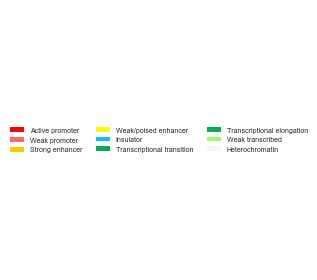

In [199]:
colors = [
    np.array((255,0,0)) / 255.,
    np.array((255,105,105)) / 255.,
    np.array((250,202,0)) / 255.,
    np.array((255,252,4)) / 255.,
    np.array((10,190,254)) / 255.,
    np.array((0,176,80)) / 255.,
    np.array((0,176,80)) / 255.,
    np.array((153,255,102)) / 255.,
    np.array((245,245,245)) / 255.,
    ]
ind = [
    'Active promoter',
    'Weak promoter',
    'Strong enhancer',
    'Weak/poised enhancer',
    'Insulator',
    'Transcriptional transition',
    'Transcriptional elongation',
    'Weak transcribed',
    'Heterochromatin',
]
colors = pd.Series(colors, index=ind)

fig,ax = plt.subplots(1, 1, figsize=(4.48, 4))
ciepy.clean_axis(ax)
rects = []
labels = []
for k in colors.index:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=colors[k]))
lgd = ax.legend(rects, labels, loc='center', prop={'size':7}, ncol=3)
for p in lgd.get_patches():
    p.set_linewidth(0)
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'pou5f1_chromHMM_legend.pdf'), transparent=True)

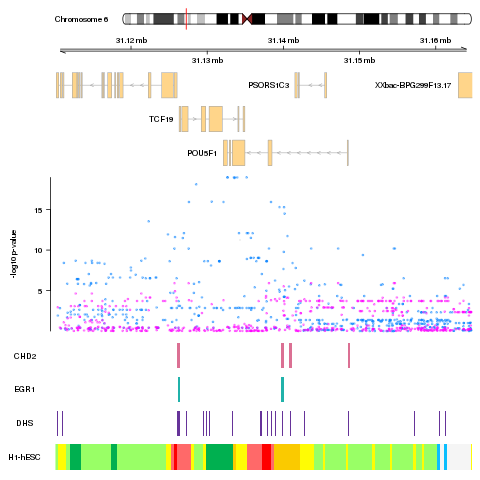

In [42]:
%%R -i start,end

plotTracks(c(ideoTrack, gtrack, biomTrack, pvalTrack, chd2Track, egr1Track, dnaseTrack, hmmTrack), chromosome="chr6", 
           from=start, to=end, col.title="black")

In [80]:
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
with open(fn) as f:
    matrices = cPickle.load(f)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
motif_info_rep = pd.read_table(fn, index_col=0)

In [188]:
def plot_tf_disruption(
    m,
    position, 
    ref, 
    alt, 
    genome_fasta,
    fn,
    title=None,
):
    """ 
    Determine whether there is a difference between the ref and alt
    alleles for TF binding.
    
    Parameters
    ----------
    m : pd.DataFrame
        PWM as data frame. Columns are nucleotides.
    
    position : str
        Zero based genomic coordinates of the reference allele of the form
        chrom:start-end (chr5:100-101 for a SNV for instance). The value end -
        start should equal the length of the ref allele.

    ref : str
        Reference allele. This should match the reference sequence at "position"
        in genome_fasta.

    alt : str
        Alternate allele.

    genome_fasta : str
        Path to genome fasta file. This file should be indexed.
        
    fn : str
        Path to write image to.

    """
    import tempfile

    from Bio.Seq import Seq
    import MOODS
    max_motif_length = m.shape[0]
    chrom, coords = position.split(':')
    start,end = [int(x) for x in coords.split('-')]
    s = '{}\t{}\t{}\n'.format(chrom, start - max_motif_length + 1, end + max_motif_length - 1)
    f = tempfile.NamedTemporaryFile(mode='w', delete=False)
    f.write(s)
    f.close()
    with open(f.name) as f:
        seq_lines = [x.strip() for x in f.readlines()]
    c = 'bedtools getfasta -fi {} -bed {} -fo /dev/stdout'.format(genome_fasta,
                                                                  f.name)
    seq_lines = subprocess.check_output(c, shell=True).split()
    os.remove(f.name)
    ref_seq = seq_lines[1]
    alt_seq = ref_seq[0:max_motif_length - 1] + alt + ref_seq[max_motif_length + len(ref) - 1:]

    ref_variant_start = max_motif_length - 1
    ref_variant_end = max_motif_length - 1 + len(ref)
    alt_variant_start = max_motif_length - 1
    alt_variant_end = max_motif_length - 1 + len(alt)

    ms = [m.T.values.tolist()]
    ref_res = MOODS.search(ref_seq, ms, 0.001, both_strands=True,
                           bg=[0.25, 0.25, 0.25, 0.25])
    alt_res = MOODS.search(alt_seq, ms, 0.001, both_strands=True,
                           bg=[0.25, 0.25, 0.25, 0.25])
    starts = set([x[0] for x in ref_res[0]]) | set([x[0] for x in alt_res[0]])
    assert len(starts) == 1

    start = list(starts)[0]

    ref_seq = ref_seq[start:start + m.shape[0]]
    alt_seq = alt_seq[start:start + m.shape[0]]
    
    if start < 0:
        ref_seq = str(Seq(ref_seq).reverse_complement())
        alt_seq = str(Seq(alt_seq).reverse_complement())

    alphabet = logo.corebio.seq.unambiguous_dna_alphabet
    prior = [0.25, 0.25, 0.25, 0.25]
    counts = m.values
    assert counts.shape[1] == 4
    assert len(ref_seq) == len(alt_seq) == counts.shape[0]
    ref_counts = []
    for t in ref_seq:
        ref_counts.append([int(t.upper() == 'A'), int(t.upper() == 'C'),
                           int(t.upper() == 'G'), int(t.upper() == 'T')])
    alt_counts = []
    for t in alt_seq:
        alt_counts.append([int(t.upper() == 'A'), int(t.upper() == 'C'),
                           int(t.upper() == 'G'), int(t.upper() == 'T')])
    counts = np.concatenate([counts, ref_counts, alt_counts])
    data = logo.LogoData.from_counts(alphabet, counts, prior=None)
    fout = open(fn, 'w')
    options = logo.LogoOptions()
    options.fineprint = ''
    if title:
        options.logo_title = title
    else:
        options.logo_title = ''
    options.stacks_per_line = m.shape[0]
    options.show_xaxis = False
    options.show_yaxis = False
    options.color_scheme = logo.ColorScheme([logo.ColorGroup("G", "orange"), 
                                             logo.ColorGroup("C", "blue"),
                                             logo.ColorGroup("A", "green"),
                                             logo.ColorGroup("T", "red")])
    logo_format = logo.LogoFormat(data, options)
    fout.write(logo.png_print_formatter(data, logo_format))
    #fout.write(logo.pdf_formatter(data, logo_format))
    fout.close()

In [189]:
position = 'chr6:31140007-31140008'
m = matrices['EGR1_known12']
ref = 'C'
alt = 'T'
plot_tf_disruption(m, position, ref, alt, cpy.hg19, os.path.join(outdir, 'EGR1.png'))

position = 'chr6:31140007-31140008'
m = matrices['CHD2_disc3']
ref = 'C'
alt = 'T'
plot_tf_disruption(m, position, ref, alt, cpy.hg19, os.path.join(outdir, 'CHD2.png'))

In [145]:
from IPython.display import Image 

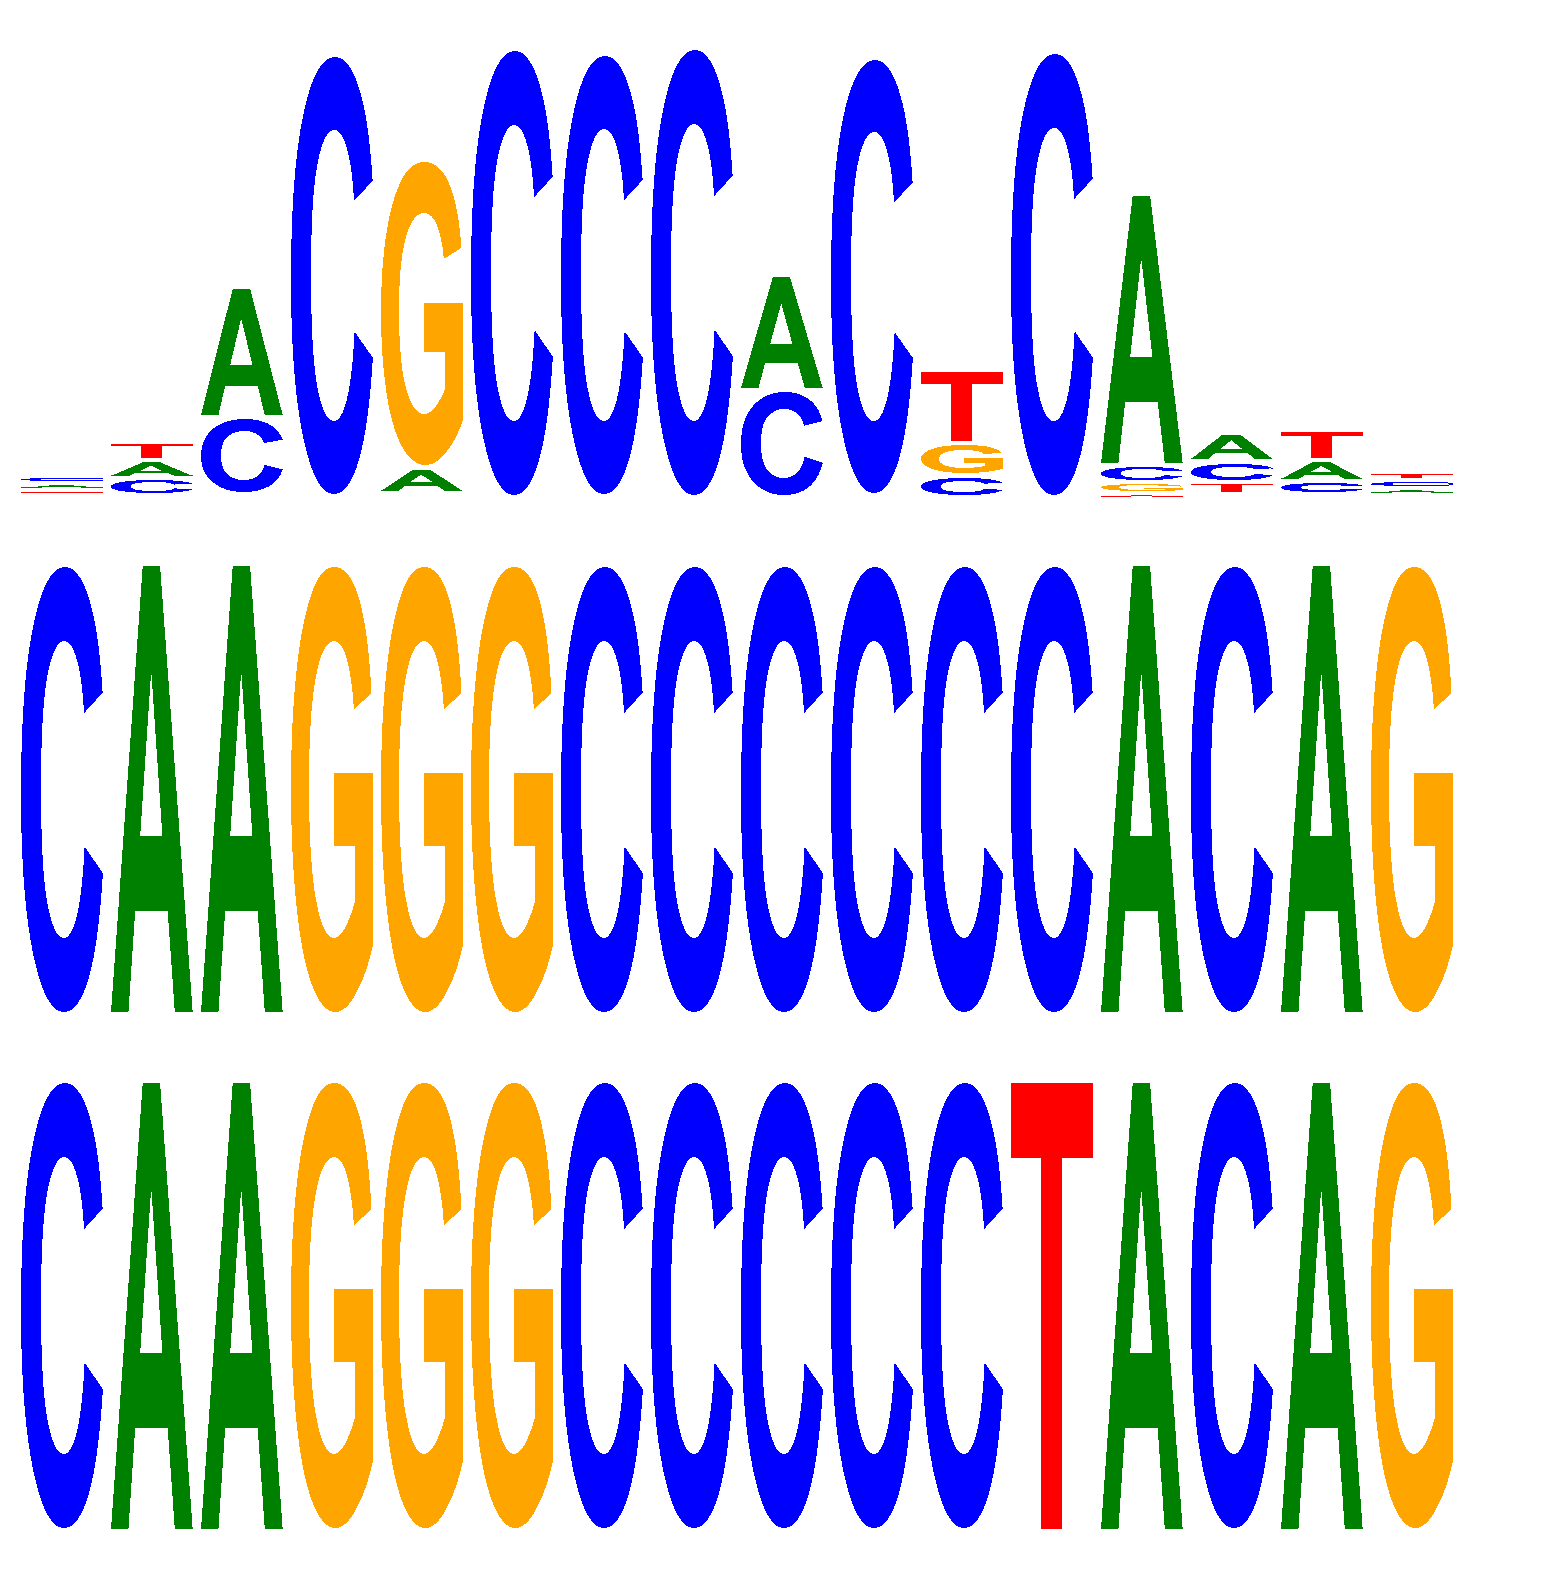

In [190]:
Image(filename=os.path.join(outdir, 'EGR1.png'), width=200)

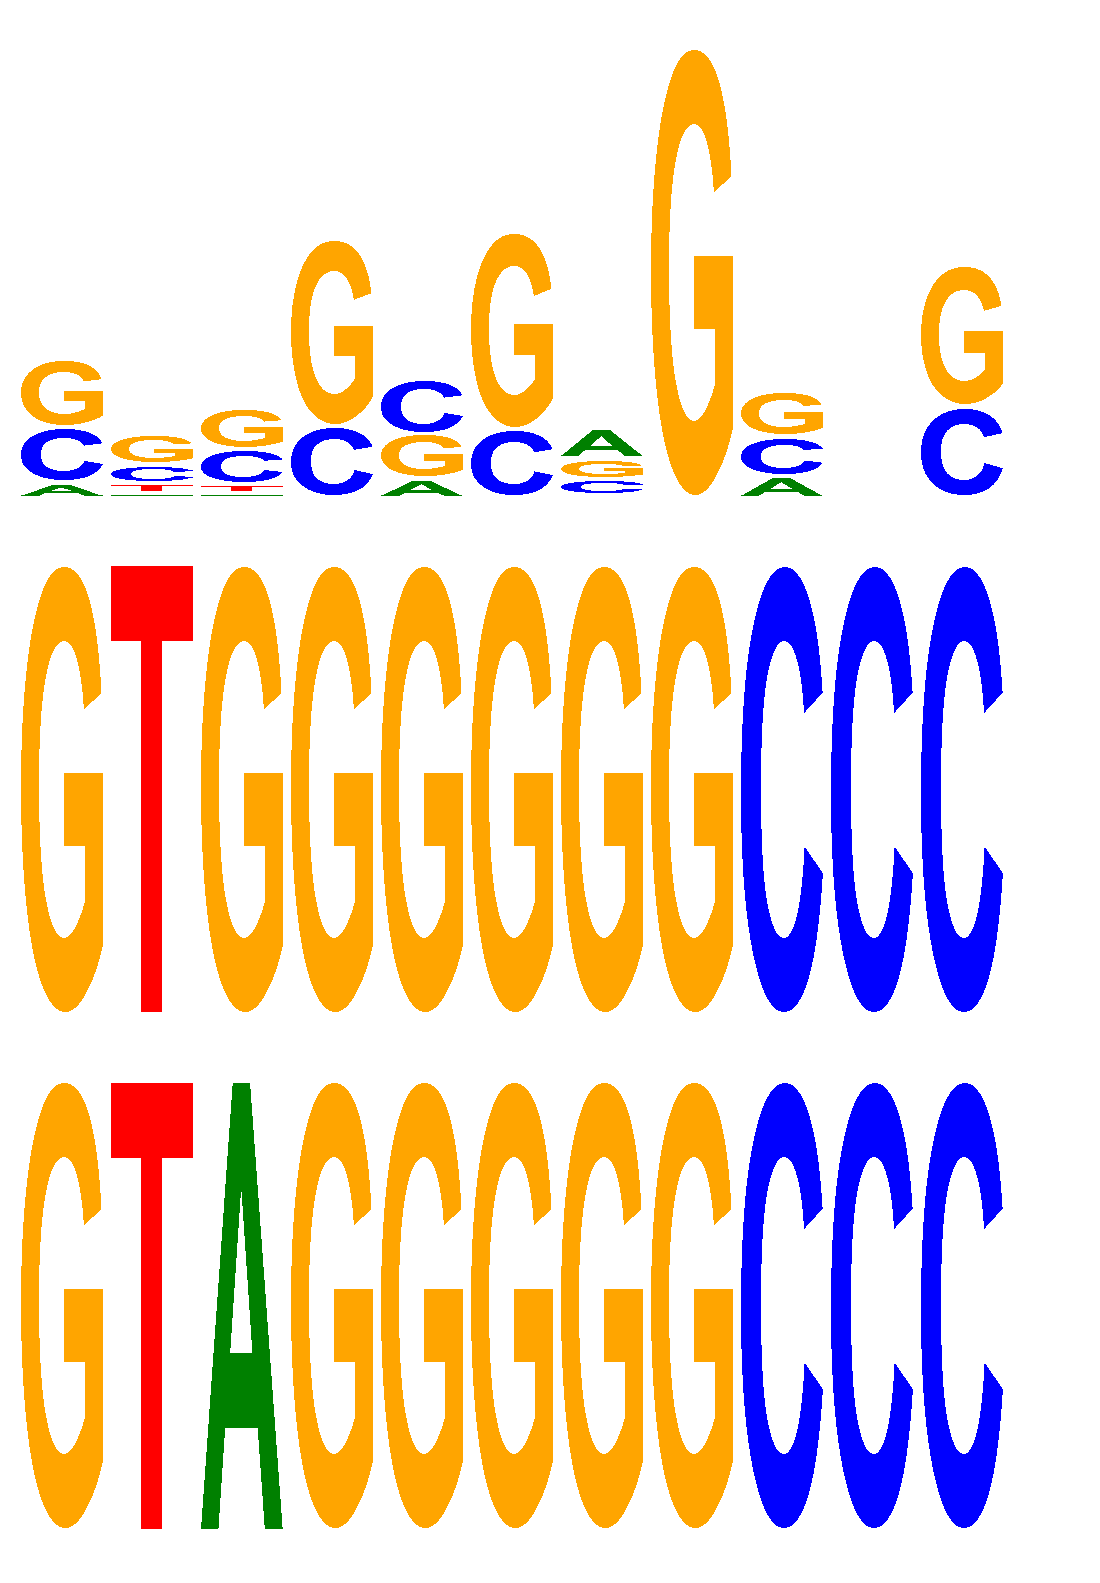

In [191]:
Image(filename=os.path.join(outdir, 'CHD2.png'), width=200)